**Determine the species of a seedling from an image**

This dataset containing images of approximately 960 unique plants belonging to 12 species at several growth stages.

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nazlimehrabi","key":"3197413652984a5320eb97ca2a818287"}'}

In [ ]:
!mkdir ~/.kaggle/

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
akshaydattatraykhare/diabetes-dataset                           Diabetes Dataset                                      9KB  2022-10-06 08:55:25           3253         99  1.0              
whenamancodes/covid-19-coronavirus-pandemic-dataset             COVID -19 Coronavirus Pandemic Dataset               11KB  2022-09-30 04:05:11           2737         81  1.0              
thedevastator/a-complete-history-of-nobel-prize-winners         Nobel Prize Winners                                   1MB  2022-10-08 00:09:57            648         23  1.0              
thedevastator/fast-food-restaurants-in-the-united-states    

In [ ]:
!kaggle competitions download -c plant-seedlings-classification

100% 1.69G/1.69G [00:19<00:00, 133MB/s]
100% 1.69G/1.69G [00:19<00:00, 95.0MB/s]


In [ ]:
!unzip plant-seedlings-classification.zip

In [ ]:
!mkdir data

In [ ]:
!mv train data/

In [ ]:
!mv ./test data/

In [ ]:
%matplotlib inline

In [ ]:
import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.functional as F #activation functions

In [ ]:
#initial setups
np.set_printoptions(precision=2)
np.random.seed(159)

In [ ]:
data_dir = './data/'
sz = 224
batch_size = 32

In [ ]:
trn_dir = f'{data_dir}/train'

In [ ]:
os.listdir(trn_dir)

['Scentless Mayweed',
 'Maize',
 'Sugar beet',
 'Fat Hen',
 'Common wheat',
 'Common Chickweed',
 'Cleavers',
 'Small-flowered Cranesbill',
 'Black-grass',
 'Shepherds Purse',
 'Loose Silky-bent',
 'Charlock']

In [ ]:
#reading all file names from train folder (png ones)
trn_fnames = glob.glob(f'{trn_dir}/*/*.png')
trn_fnames[:5]

['./data//train/Scentless Mayweed/f3f60c384.png',
 './data//train/Scentless Mayweed/d748c7307.png',
 './data//train/Scentless Mayweed/3585db717.png',
 './data//train/Scentless Mayweed/299bd761f.png',
 './data//train/Scentless Mayweed/0e4c95d3a.png']

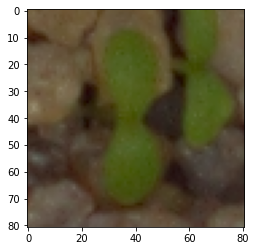

In [ ]:
img3 = plt.imread(trn_fnames[3]) #convert an image to a matrix
plt.imshow(img3);

In [ ]:
#Transformations
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.456], [0.229, 0.224, 0.225]) #mean and standard deviation of RGBs form imagenet data 
    ])

#redefile
trn_ds = datasets.ImageFolder(trn_dir, transform = tfms)

In [ ]:
len(trn_ds)

4750

In [ ]:
train_ds, test_ds = torch.utils.data.random_split(trn_ds, [4000, 750])

In [ ]:
train_ds, val_ds = torch.utils.data.random_split(train_ds, [3750, 250])

In [ ]:
len(train_ds), len(val_ds)

(3750, 250)

In [ ]:
#dataloaders
train_dl = torch.utils.data.DataLoader(train_ds, 
                                      batch_size = batch_size,
                                      shuffle = True,
                                      num_workers = 2)

val_dl = torch.utils.data.DataLoader(val_ds,
                                    batch_size = batch_size,
                                    shuffle = True,
                                    num_workers = 2)

In [ ]:
#let's look at the inside of the train_loader 
for i, j in train_dl:
    print(i)
    print(j)
    break

tensor([[[[-0.6281, -0.7650, -0.9705,  ..., -0.7479, -0.6452, -0.6794],
          [-0.6109, -0.6623, -0.9363,  ..., -0.9020, -0.6965, -0.7308],
          [-0.6109, -0.6452, -0.8849,  ..., -0.8164, -0.7308, -0.6965],
          ...,
          [-1.0562, -1.1760, -1.1760,  ..., -0.4911, -0.1828, -0.0801],
          [-1.0390, -1.0219, -1.0904,  ..., -0.4739, -0.1486, -0.0458],
          [-0.8849, -0.8849, -0.9705,  ..., -0.3883, -0.0972, -0.0116]],

         [[-0.6352, -0.8978, -1.2479,  ..., -0.9328, -0.8277, -0.8277],
          [-0.5826, -0.7227, -1.1779,  ..., -1.1078, -0.8627, -0.8978],
          [-0.6352, -0.7227, -1.0728,  ..., -0.9853, -0.8803, -0.8277],
          ...,
          [-1.2479, -1.3354, -1.3529,  ..., -0.5476, -0.2150, -0.1275],
          [-1.1954, -1.1779, -1.2654,  ..., -0.5476, -0.1800, -0.0924],
          [-1.0903, -1.0903, -1.1954,  ..., -0.4601, -0.1275, -0.0574]],

         [[-0.7195, -1.0332, -1.4515,  ..., -1.2249, -1.1029, -1.1203],
          [-0.6323, -0.7892, -

torch.Size([32, 3, 224, 224])
torch.Size([3, 1810, 906])


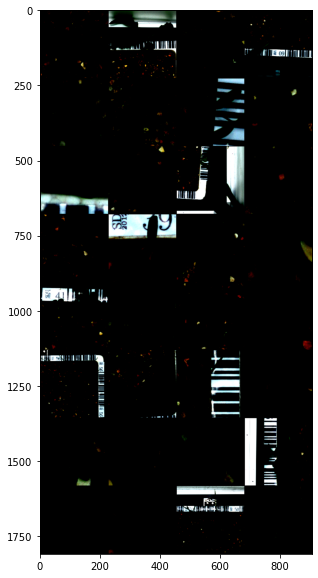

In [ ]:
#let's look at a batch of the images (after the transformation)
print(i.shape)
images = make_grid(i, nrow=4)  
print(images.shape)
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(images.numpy(), (1, 2, 0)));

In [ ]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1)
        nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1)
        nn.BatchNorm2d(20)
        nn.Dropout(0.1)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=3, stride=1)
        nn.BatchNorm2d(30)
        nn.Dropout(0.1)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=40, kernel_size=3, stride=1)
        nn.BatchNorm2d(40)
        nn.Dropout(0.1)
        self.conv5 = nn.Conv2d(in_channels=40, out_channels=50, kernel_size=3, stride=1)
        nn.BatchNorm2d(50)
        nn.Dropout(0.5)
        self.conv6 = nn.Conv2d(in_channels=50, out_channels=50, kernel_size=3, stride=1)
        nn.BatchNorm2d(50)
        nn.Dropout(0.5)
        self.fc1 = nn.Linear(24*24*50, 400)
        self.fc2 = nn.Linear(400, 200)
        self.fc3 = nn.Linear(200, 12)

    def forward(self, X):
        X = F.relu(self.conv1(X)) #224*224 => 222*222 
        X = F.relu(self.conv2(X)) #222*222 => 220*220
        X = F.max_pool2d(X, 2, 2) #220*220 => 110*110
        X = F.relu(self.conv3(X)) #110*110 => 108*108
        X = F.relu(self.conv4(X)) #108*108 => 106*106
        X = F.max_pool2d(X, 2, 2) #106*106 => 53*53  
        X = F.relu(self.conv5(X)) #53*53 => 51*51
        X = F.relu(self.conv6(X)) #51*51 => 49*49
        X = F.max_pool2d(X, 2, 2) #49*49 => 24*24
        X = X.view(-1, 24*24*50)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [ ]:
model = CNN()

#transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    return 'accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset))

In [ ]:
evaluate_model(model, val_dl, device)

'accuracy: 6.80'

In [ ]:
num_epochs = 14

for epoch in range(num_epochs):
    losses = []
    for batch, (inputs, targets) in enumerate(train_dl):
        #forwad pass
        outputs = model(inputs)
        
        #loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        predicted = torch.max(outputs.data, 1)[1]

        #backward pass(calculate the gradients)
        optimizer.zero_grad()
        loss.backward()
        
        #update parameters
        optimizer.step()
        
    print("Epoch: " + str(epoch) + ". Mean loss: " + str(sum(losses)/len(losses)) + ".")
    print("On train: ", evaluate_model(model, train_dl, device))
    print("On validation: ", evaluate_model(model, val_dl, device))

Epoch: 0. Mean loss: 2.426841349925025.
On train:  accuracy: 13.97
On validation:  accuracy: 14.00
Epoch: 1. Mean loss: 2.414656152159481.
On train:  accuracy: 15.81
On validation:  accuracy: 16.80
Epoch: 2. Mean loss: 1.831235964419478.
On train:  accuracy: 48.72
On validation:  accuracy: 46.80
Epoch: 3. Mean loss: 1.3788870406352867.
On train:  accuracy: 55.79
On validation:  accuracy: 53.20
Epoch: 4. Mean loss: 1.1740681574506275.
On train:  accuracy: 67.07
On validation:  accuracy: 61.20
Epoch: 5. Mean loss: 0.8993452888424114.
On train:  accuracy: 76.13
On validation:  accuracy: 66.00
Epoch: 6. Mean loss: 0.6943565053960025.
On train:  accuracy: 80.56
On validation:  accuracy: 68.80
Epoch: 7. Mean loss: 0.5782127913277028.
On train:  accuracy: 85.55
On validation:  accuracy: 68.80
Epoch: 8. Mean loss: 0.46347459816073966.
On train:  accuracy: 86.08
On validation:  accuracy: 71.60
Epoch: 9. Mean loss: 0.3844838316662837.
On train:  accuracy: 88.96
On validation:  accuracy: 70.00
Ep